In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
from diffusion.models.network import ResUNet, get_network
from tqdm.notebook import tqdm
import os
from torchvision import transforms
import json

from datahandler.dataset import NPDataset, make_dataset, RandomRotate90
import matplotlib.pyplot as plt
from diffusion.dm import DiscreteSBM, get_diffusion_model, DiffusionModel
from diffusion.stochastic.sde import DiscreteVPSDE, DiscreteSigmaVPSDE, get_sde, DiscreteSDE
from utils.scheduler import get_optimizer_and_scheduler

In [2]:
import runners as runners

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')
amin, amax = -5, 5

In [4]:
train_dataset, test_dataset = make_dataset("CATS_MHD_BPROJ_DENSITY", seed=33, split=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

In [5]:
power_spectrum = np.load("/mnt/home/dheurtel/AstroDDPM/diffusion/stochastic/power_spectra/cmb_256_8arcmippixel.npy", allow_pickle=True)

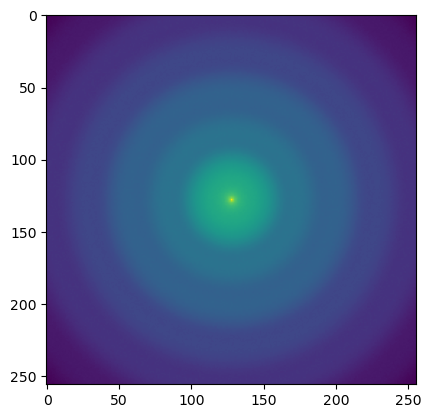

In [6]:
plt.imshow(np.fft.fftshift(np.log(power_spectrum)))

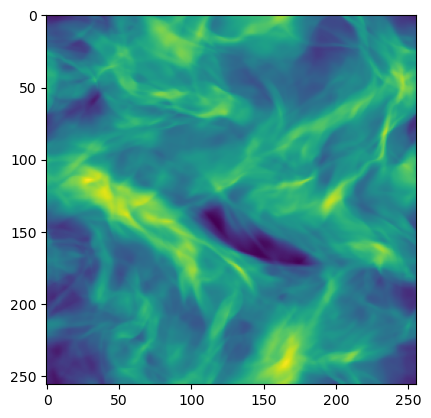

In [7]:
## Plot the first element of train_dataset

plt.imshow(train_dataset[0].numpy())

In [8]:
sde = DiscreteSigmaVPSDE(1000, power_spectrum='cmb_256_8arcmippixel', ddpm_math=True)

In [9]:
data = next(iter(train_loader))
data = data.to(device)
data = data.unsqueeze(1)
timesteps = (torch.randint(0, 1000, (data.shape[0],))).long().to(device)

x_tilde, mean, noise = sde.sampling(data, timesteps)

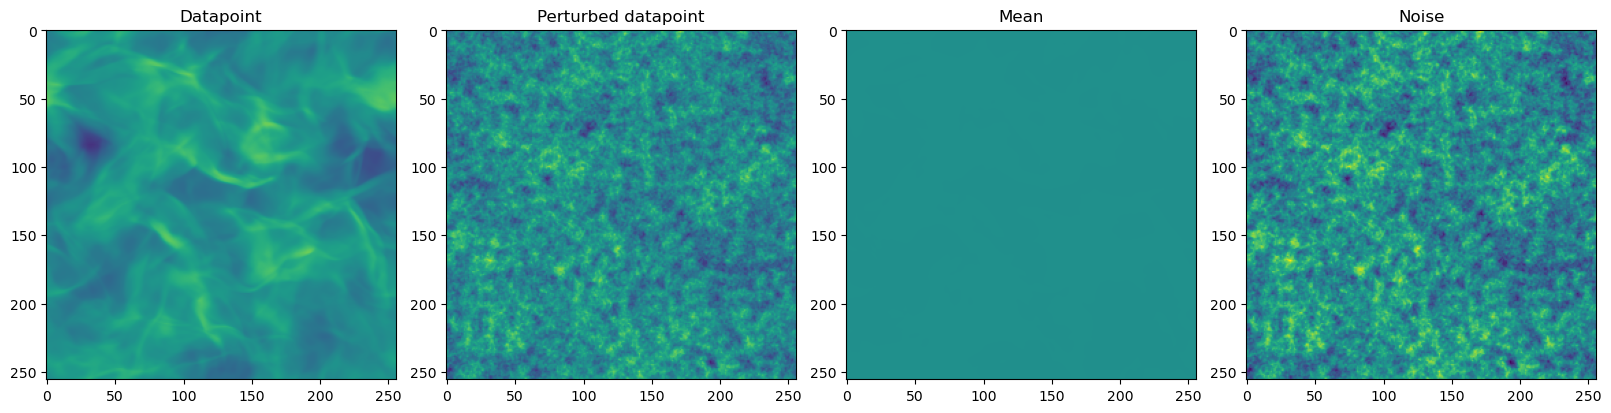

In [10]:
## Plot one image one one line of the initial batch called data, and the sampled images x_tilde, along with the mean and noise terms

fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
axs[0].imshow(data[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[0].set_title("Datapoint")
axs[1].imshow(x_tilde[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[1].set_title("Perturbed datapoint")
axs[2].imshow(mean[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[2].set_title("Mean")
axs[3].imshow(noise[0, 0, :, :].cpu().numpy(),)
axs[3].set_title("Noise")
plt.show()

In [11]:
network = ResUNet(1, 1, 10, num_blocks=1, n_steps=1000, time_emb_dim=100, dropout=0, attention=[], normalisation="GN", padding_mode="circular", eps_norm=1e-5, skiprescale=True)
model = DiscreteSBM(sde, network)
diffuser = runners.Diffuser(model, continuity = 'discrete', dataset = "MHD")
optimizer = torch.optim.AdamW(network.parameters(), lr=1e-3, weight_decay=1e-5)

In [12]:
with open("test.json") as f:
    test_dict = json.load(f)

In [13]:
test_dict = {}

In [36]:
test_dict["DefaultDDPM"]={}
test_dict["DefaultDDPM"]["model_id"] = "DefaultDDPM"

sde = DiscreteVPSDE(1000)
network = ResUNet()
model = DiscreteSBM(sde, network)

test_dict["DefaultDDPM"]["diffusion_model"] = model.config

dataloaders_dict = {}
dataloaders_dict["train_batch_size"] = 64
dataloaders_dict["test_batch_size"] = 128
dataloaders_dict["num_workers"] = 8
dataloaders_dict["pin_memory"] = True
dataloaders_dict["seed"] = 33
dataloaders_dict["split"] = 0.1
dataloaders_dict["dataset"] = train_dataset.config

test_dict["DefaultDDPM"]["dataloaders"] = dataloaders_dict

test_dict["DefaultDDPM"]["optimizer"] = {"type" : "Adam", "lr" : 1e-3, "weight_decay" : 0}

test_dict["DefaultDDPM"]["scheduler"] = {"type": "invpower", "warmup" : 100, "maxlr" : 1e-3, "power": 0.2, "last_step": -1}

test_dict["DefaultDDPM"]["use_gpu"] = True

test_dict["DefaultDDPM"]["logging"] = True
test_dict["DefaultDDPM"]["log_dir"] = "test_log_dir"
test_dict["DefaultDDPM"]["log_wandb"] = True
test_dict["DefaultDDPM"]["log_tensorboard"] = True

test_dict["DefaultDDPM"]["ckpt_step"] = 100
test_dict["DefaultDDPM"]["ckpt_dir"] = "ckpt_dir"

test_dict["DefaultDDPM"]["sample_step"] = 100
test_dict["DefaultDDPM"]["sample_dir"] = "sample_dir"
test_dict["DefaultDDPM"]["sample_size"] = 64

In [37]:
optim, sched = get_optimizer_and_scheduler({"scheduler" : {"type": "invpower", "warmup" : 100, "maxlr" : 1e-3, 'maxstep' : 10000, "power": 0.2, "step_period": 1000}}, network.parameters())

Optimizer type not specified. Using default optimizer: Adam


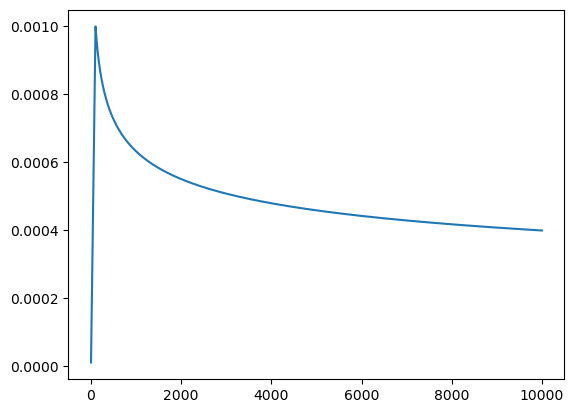

In [38]:
steps = range(10000)
lrs = []
for step in steps:
    sched.step()
    lrs.append(optim.param_groups[0]['lr'])
plt.plot(steps, lrs)

In [42]:
test_dict

{'DefaultDDPM': {'model_id': 'DefaultDDPM',
  'diffusion_model': {'sde': {'type': 'DiscreteVPSDE',
    'beta_min': 0.1,
    'beta_max': 20.0,
    'ddpm_math': True,
    'N': 1000},
   'network': {'in_c': 1,
    'out_c': 1,
    'first_c': 10,
    'sizes': [256, 128, 64, 32],
    'num_blocks': 1,
    'n_steps': 1000,
    'time_emb_dim': 100,
    'dropout': 0,
    'attention': [],
    'normalisation': 'default',
    'padding_mode': 'circular',
    'eps_norm': 1e-05,
    'skiprescale': False,
    'type': 'ResUNet'},
   'type': 'DiscreteSBM'},
  'dataloaders': {'train_batch_size': 64,
   'test_batch_size': 128,
   'num_workers': 8,
   'pin_memory': True,
   'seed': 33,
   'split': 0.1,
   'dataset': {'dir': '/mnt/home/dheurtel/ceph/01_data/CATS_MHD_BPROJ_DENSITY/',
    'type': 'npy files',
    'transforms': ['Random_Rotate90'],
    'name': 'CATS_MHD_BPROJ_DENSITY'}},
  'optimizer': {'type': 'Adam', 'lr': 0.001, 'weight_decay': 0},
  'scheduler': {'type': 'invpower',
   'warmup': 100,
   'ma

In [16]:
diffuser2 = runners.Diffuser(model, continuity = 'discrete', dataset = "CATS_MHD_BPROJ_DENSITY")

In [17]:
diffuser2.load(config = test_dict["TestDiffuser"])

Loading the diffuser from a config dict or json file.


In [18]:
data = next(iter(diffuser2.train_dataloader)).to(device).unsqueeze(1)
timesteps = (torch.randint(0, 1000, (data.shape[0],))).long().to(device)
x_tilde, mean, noise = diffuser2.diffmodel.sde.sampling(data, timesteps)

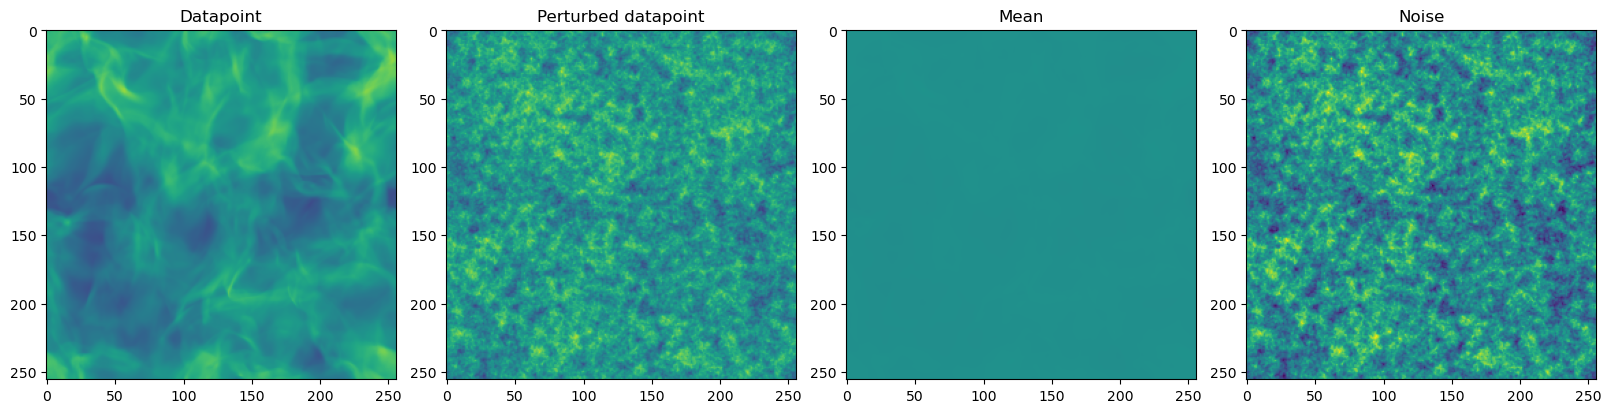

In [19]:
## Plot one image one one line of the initial batch called data, and the sampled images x_tilde, along with the mean and noise terms

fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
axs[0].imshow(data[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[0].set_title("Datapoint")
axs[1].imshow(x_tilde[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[1].set_title("Perturbed datapoint")
axs[2].imshow(mean[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[2].set_title("Mean")
axs[3].imshow(noise[0, 0, :, :].cpu().numpy(),)
axs[3].set_title("Noise")
plt.show()

In [44]:
## load test_dict to the json file it came from

with open("./config/MODELS.json", "w") as f:
    json.dump(test_dict, f, indent=4)


In [21]:
sde = DiscreteVPSDE(1000)

In [22]:
test_dict["TestDiffuser"]["diffusion_model"]["sde"] = sde.config

In [23]:
test_dict["TestDiffuser"]["scheduler"] = {}

In [24]:
diffuser2.load(config = test_dict["TestDiffuser"])

Loading the diffuser from a config dict or json file.


In [25]:
diffuser2.train_dataloader.batch_size

32

In [61]:
losses, test_losses = diffuser2.train(epochs=200)

Epoch 2: 100%|██████████| 27/27 [00:02<00:00, 10.07it/s, loss=0.0532, step=80]
Exception ignored in: <function _releaseLock at 0x155553298ee0>
Traceback (most recent call last):
  File "/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Epoch 6:  78%|███████▊  | 21/27 [00:02<00:00, 11.57it/s, loss=0.0563, step=182]

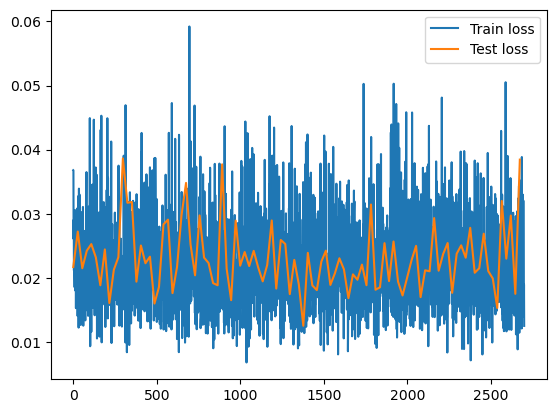

In [46]:
## Plot the losses, adjusting for the fact that test losses are only computed each epoch
len(losses), len(test_losses)

plt.plot(np.arange(len(losses)), losses, label="Train loss")
plt.plot(np.arange(0, len(losses), 27), test_losses, label="Test loss")
plt.legend()

In [47]:
gen = diffuser2.diffmodel.generate_image(4, 1, 256)

100%|██████████| 1000/1000 [00:06<00:00, 163.00it/s]


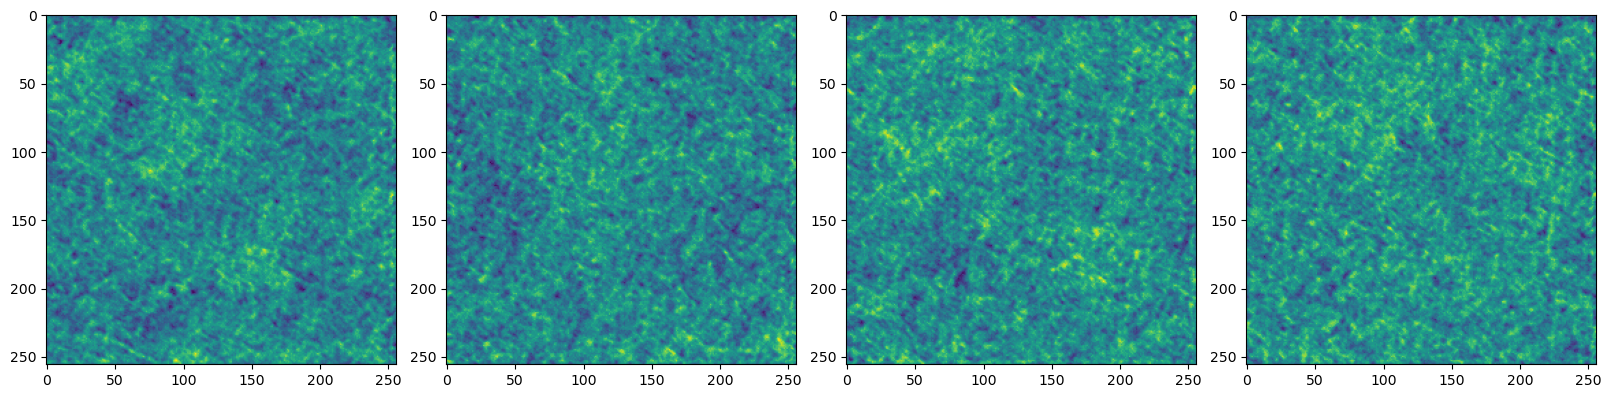

In [49]:
## Plot the generated images

fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
for i in range(4):
    axs[i].imshow(gen[i, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
plt.show()

In [88]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor(
        [[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)]
    )
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [89]:
emb = sinusoidal_embedding(10000, 100)

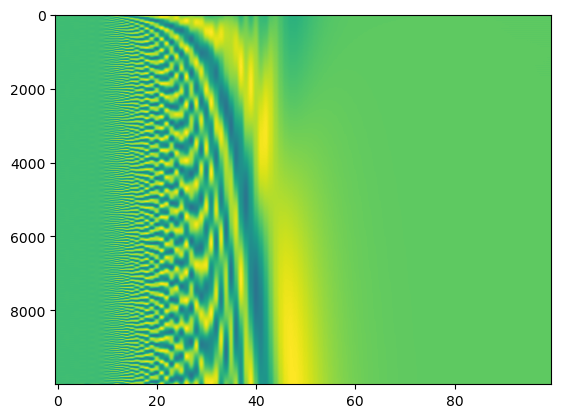

In [90]:
plt.imshow(emb, aspect="auto")

In [91]:
dim = 100

In [92]:
t_tilde = - np.log(10)*8*torch.arange(0, dim)/dim

t_tilde = torch.exp(t_tilde)

def embeder(t , T, scaling = 1000):
    partial_embedding = torch.einsum('i,j->ij',(scaling*t/T).T,t_tilde)
    
    return partial_embedding

In [101]:
def fun(x):
    return torch.sin(x)*torch.cos(x)

In [102]:
torch.arange(0, 100).float().requires_grad_(True)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
        98., 99.], requires_grad=True)

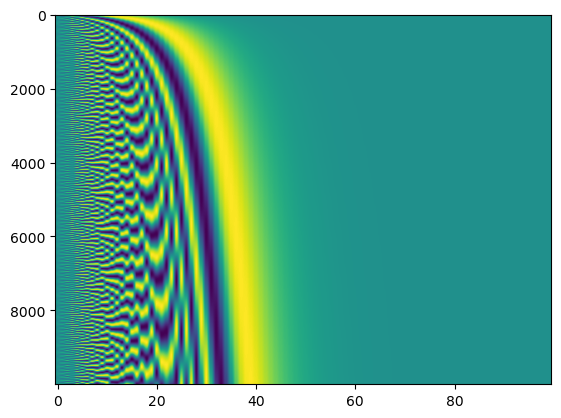

In [103]:
plt.imshow(fun(embeder(torch.arange(0, 10000), 10000)), aspect="auto")

In [53]:
embeder(torch.arange(0, 1000), 1000)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e-03, 8.3176e-04, 6.9183e-04,  ..., 1.7378e-11, 1.4454e-11,
         1.2023e-11],
        [2.0000e-03, 1.6635e-03, 1.3837e-03,  ..., 3.4756e-11, 2.8909e-11,
         2.4045e-11],
        ...,
        [9.9700e-01, 8.2927e-01, 6.8976e-01,  ..., 1.7326e-08, 1.4411e-08,
         1.1987e-08],
        [9.9800e-01, 8.3010e-01, 6.9045e-01,  ..., 1.7343e-08, 1.4425e-08,
         1.1999e-08],
        [9.9900e-01, 8.3093e-01, 6.9114e-01,  ..., 1.7361e-08, 1.4440e-08,
         1.2011e-08]])

In [15]:
import abc

In [16]:
class SDE(abc.ABC):
  """SDE abstract class. Functions are designed for a mini-batch of inputs."""

  def __init__(self, N):
    """Construct an SDE.

    Args:
      N: number of discretization time steps.
    """
    super().__init__()
    self.N = N

  @property
  @abc.abstractmethod
  def T(self):
    """End time of the SDE."""
    pass

  @abc.abstractmethod
  def sde(self, x, t):
    pass

  @abc.abstractmethod
  def marginal_prob(self, x, t):
    """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
    pass

  @abc.abstractmethod
  def prior_sampling(self, shape):
    """Generate one sample from the prior distribution, $p_T(x)$."""
    pass

  @abc.abstractmethod
  def prior_logp(self, z):
    """Compute log-density of the prior distribution.

    Useful for computing the log-likelihood via probability flow ODE.

    Args:
      z: latent code
    Returns:
      log probability density
    """
    pass

  def discretize(self, x, t):
    """Discretize the SDE in the form: x_{i+1} = x_i + f_i(x_i) + G_i z_i.

    Useful for reverse diffusion sampling and probabiliy flow sampling.
    Defaults to Euler-Maruyama discretization.

    Args:
      x: a torch tensor
      t: a torch float representing the time step (from 0 to `self.T`)

    Returns:
      f, G
    """
    dt = 1 / self.N
    drift, diffusion = self.sde(x, t)
    f = drift * dt
    G = diffusion * torch.sqrt(torch.tensor(dt, device=t.device))
    return f, G

  def reverse(self, score_fn, probability_flow=False):
    """Create the reverse-time SDE/ODE.

    Args:
      score_fn: A time-dependent score-based model that takes x and t and returns the score.
      probability_flow: If `True`, create the reverse-time ODE used for probability flow sampling.
    """
    N = self.N
    T = self.T
    sde_fn = self.sde
    discretize_fn = self.discretize

    # Build the class for reverse-time SDE.
    class RSDE(self.__class__):
      def __init__(self):
        self.N = N
        self.probability_flow = probability_flow

      @property
      def T(self):
        return T

      def sde(self, x, t):
        """Create the drift and diffusion functions for the reverse SDE/ODE."""
        drift, diffusion = sde_fn(x, t)
        score = score_fn(x, t)
        drift = drift - diffusion[:, None, None, None] ** 2 * score * (0.5 if self.probability_flow else 1.)
        # Set the diffusion function to zero for ODEs.
        diffusion = 0. if self.probability_flow else diffusion
        return drift, diffusion

      def discretize(self, x, t):
        """Create discretized iteration rules for the reverse diffusion sampler."""
        f, G = discretize_fn(x, t)
        rev_f = f - G[:, None, None, None] ** 2 * score_fn(x, t) * (0.5 if self.probability_flow else 1.)
        rev_G = torch.zeros_like(G) if self.probability_flow else G
        return rev_f, rev_G

    return RSDE()


In [17]:
class VPSDE(SDE):
  def __init__(self, beta_min=0.1, beta_max=20, N=1000):
    """Construct a Variance Preserving SDE.

    Args:
      beta_min: value of beta(0)
      beta_max: value of beta(1)
      N: number of discretization steps
    """
    super().__init__(N)
    self.beta_0 = beta_min
    self.beta_1 = beta_max
    self.N = N
    self.discrete_betas = torch.linspace(beta_min / N, beta_max / N, N)
    self.alphas = 1. - self.discrete_betas
    self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
    self.sqrt_1m_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

  @property
  def T(self):
    return 1

  def sde(self, x, t):
    beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
    drift = -0.5 * beta_t[:, None, None, None] * x
    diffusion = torch.sqrt(beta_t)
    return drift, diffusion

  def marginal_prob(self, x, t):
    log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
    mean = torch.exp(log_mean_coeff[:, None, None, None]) * x
    std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
    return mean, std

  def prior_sampling(self, shape):
    return torch.randn(*shape)

  def prior_logp(self, z):
    shape = z.shape
    N = np.prod(shape[1:])
    logps = -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1, 2, 3)) / 2.
    return logps

  def discretize(self, x, t):
    """DDPM discretization."""
    timestep = (t * (self.N - 1) / self.T).long()
    beta = self.discrete_betas.to(x.device)[timestep]
    alpha = self.alphas.to(x.device)[timestep]
    sqrt_beta = torch.sqrt(beta)
    f = torch.sqrt(alpha)[:, None, None, None] * x - x
    G = sqrt_beta
    return f, G


class subVPSDE(SDE):
  def __init__(self, beta_min=0.1, beta_max=20, N=1000):
    """Construct the sub-VP SDE that excels at likelihoods.

    Args:
      beta_min: value of beta(0)
      beta_max: value of beta(1)
      N: number of discretization steps
    """
    super().__init__(N)
    self.beta_0 = beta_min
    self.beta_1 = beta_max
    self.N = N

  @property
  def T(self):
    return 1

  def sde(self, x, t):
    beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
    drift = -0.5 * beta_t[:, None, None, None] * x
    discount = 1. - torch.exp(-2 * self.beta_0 * t - (self.beta_1 - self.beta_0) * t ** 2)
    diffusion = torch.sqrt(beta_t * discount)
    return drift, diffusion

  def marginal_prob(self, x, t):
    log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
    mean = torch.exp(log_mean_coeff)[:, None, None, None] * x
    std = 1 - torch.exp(2. * log_mean_coeff)
    return mean, std

  def prior_sampling(self, shape):
    return torch.randn(*shape)

  def prior_logp(self, z):
    shape = z.shape
    N = np.prod(shape[1:])
    return -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1, 2, 3)) / 2.


class VESDE(SDE):
  def __init__(self, sigma_min=0.01, sigma_max=50, N=1000):
    """Construct a Variance Exploding SDE.

    Args:
      sigma_min: smallest sigma.
      sigma_max: largest sigma.
      N: number of discretization steps
    """
    super().__init__(N)
    self.sigma_min = sigma_min
    self.sigma_max = sigma_max
    self.discrete_sigmas = torch.exp(torch.linspace(np.log(self.sigma_min), np.log(self.sigma_max), N))
    self.N = N

  @property
  def T(self):
    return 1

  def sde(self, x, t):
    sigma = self.sigma_min * (self.sigma_max / self.sigma_min) ** t
    drift = torch.zeros_like(x)
    diffusion = sigma * torch.sqrt(torch.tensor(2 * (np.log(self.sigma_max) - np.log(self.sigma_min)),
                                                device=t.device))
    return drift, diffusion

  def marginal_prob(self, x, t):
    std = self.sigma_min * (self.sigma_max / self.sigma_min) ** t
    mean = x
    return mean, std

  def prior_sampling(self, shape):
    return torch.randn(*shape) * self.sigma_max

  def prior_logp(self, z):
    shape = z.shape
    N = np.prod(shape[1:])
    return -N / 2. * np.log(2 * np.pi * self.sigma_max ** 2) - torch.sum(z ** 2, dim=(1, 2, 3)) / (2 * self.sigma_max ** 2)

  def discretize(self, x, t):
    """SMLD(NCSN) discretization."""
    timestep = (t * (self.N - 1) / self.T).long()
    sigma = self.discrete_sigmas.to(t.device)[timestep]
    adjacent_sigma = torch.where(timestep == 0, torch.zeros_like(t),
                                 self.discrete_sigmas[timestep - 1].to(t.device))
    f = torch.zeros_like(x)
    G = torch.sqrt(sigma ** 2 - adjacent_sigma ** 2)
    return f, G

In [18]:
vpsde = VPSDE(0.1, 20, 1000)

In [19]:
vpsde.sde(torch.randn(1, 3, 32, 32), torch.tensor([0.5]))

(tensor([[[[ 2.9753,  5.0822, -2.0389,  ..., -1.6737, -2.2968, -3.3191],
           [-5.6412, -3.0274,  1.8613,  ...,  1.4571,  4.5863,  9.0894],
           [-2.8378, -6.3113,  7.9066,  ..., -2.0258, -3.8199, -2.5729],
           ...,
           [-4.8765,  4.4334,  4.4606,  ...,  2.3934, -2.6036, -1.2455],
           [ 3.7662, -2.1921, -4.3879,  ..., -0.4403, -6.3593, -0.8369],
           [-4.7143,  1.1418,  0.7059,  ...,  6.3758,  0.7300, -5.0995]],
 
          [[-1.8839,  1.3180,  1.6696,  ..., -5.7366,  5.1270,  8.8524],
           [ 4.0490,  3.7448,  3.6999,  ..., -6.2532, -3.1695,  3.5742],
           [-4.3785,  6.9194, -2.0513,  ...,  1.5426,  5.0828,  4.6795],
           ...,
           [ 5.5353,  4.9756,  3.2062,  ...,  0.9089, -0.7478, -1.9401],
           [ 0.2816,  0.6530, -3.1974,  ...,  5.0368,  8.6991, -4.6788],
           [10.4762,  5.3021,  7.8980,  ..., -0.2068, -4.7139, -1.8431]],
 
          [[-2.5544, 10.7581,  4.3644,  ...,  5.7213,  0.3007, -7.0110],
           [ 